In [1]:
import os
import sys
sys.path.insert(0, os.path.realpath('__file__'))

import FLife
import lvm_read
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as si
from scipy.integrate import quad

Read the time-history data from file m1.lvm

In [2]:
data = lvm_read.read('./data/m1.lvm')[0]
t = data['data'][:,0]
x = data['data'][:,1]

Set parameters for fatigue-life estimation and scale the time signal

In [3]:
C = 1.8e+22  # S-N curve intercept [MPa]
k = 7.3 # S-N curve inverse slope [/]
Su = 446 # Ultimate tensile strength [MPa]
rms = 100  
x = rms * x / np.std(x) 

Instantiate an object of type spectralData and depict PSD

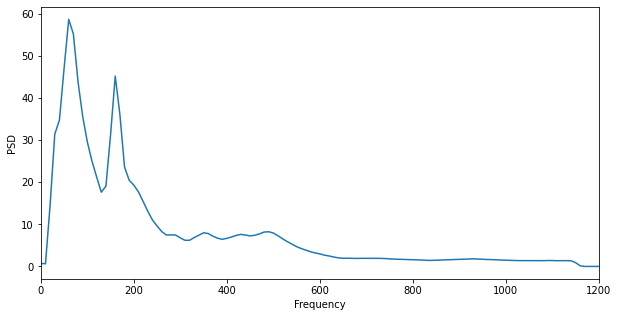

In [4]:
sd = FLife.SpectralData(input=x, dt=t[1], nperseg=int(0.1/t[1]))

plt.figure(figsize=(10,5))
plt.plot(sd.psd[:,0],sd.psd[:,1])
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.xlim(0,1200)
plt.show()

Instantiation of Fatigue-Life estimation method objects, including Rainflow counting cycle algorithm as reference

In [5]:
#Rainflow
rf = FLife.Rainflow(sd) # Do not be confused here: the spectral data object also has time domain data!

# Spectral methods
dirlik = FLife.Dirlik(sd)
tb = FLife.TovoBenasciutti(sd)
zb = FLife.ZhaoBaker(sd)
nb = FLife.Narrowband(sd)
a075 = FLife.Alpha075(sd)
wl = FLife.WirschingLight(sd)
rice = FLife.Rice(sd)   
gm = FLife.GaoMoan(sd)
gm_bf = FLife.GaoMoan(sd, band_frequency=[300,1200]) #user specified upper band frequency
pz = FLife.PetrucciZuccarello(sd)

Define stress vector and depict stress peak PDF

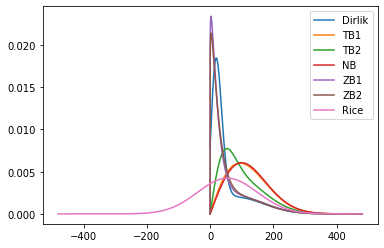

Integrals of PDF should be 1!
             Dirlik:     1
         Narrowband:     1
          Rice -inf:     1
 Tovo Benasciutti 1:     1
 Tovo Benasciutti 2:     1
       Zhao Baker 1:     1
       Zhao Baker 2:     1


In [10]:
s = np.arange(0,np.max(x),.001)
s_rice  = np.arange(-np.max(x),np.max(x),.001) #Rice combines Rayleigh and standard Gaussian function, so negative stress amplitudes should be considered also, for pdf only

#Show PDF functions
plt.plot(s,dirlik.get_PDF(s), label='Dirlik')
plt.plot(s,tb.get_PDF(s, method='method 1'), label='TB1')
plt.plot(s,tb.get_PDF(s, method='method 2'), label='TB2')
plt.plot(s,nb.get_PDF(s), label='NB')
plt.plot(s,zb.get_PDF(s, method='method 1'), label='ZB1')
plt.plot(s,zb.get_PDF(s, method='method 2'), label='ZB2')
plt.plot(s_rice,rice.get_PDF(s_rice), label='Rice')
plt.legend()
plt.show()


#Integral of PDF should be 1!
PDFs = {
    'Dirlik': quad(dirlik.get_PDF, a=0, b=np.Inf)[0],
    'Narrowband': quad(nb.get_PDF, a=0, b=np.Inf)[0],
    'Rice -inf': quad(rice.get_PDF, a=-np.Inf, b=np.Inf)[0],
    'Tovo Benasciutti 1': quad(tb.get_PDF, a=0, b=np.Inf, args=('method 1',))[0],
    'Tovo Benasciutti 2': quad(tb.get_PDF, a=0, b=np.Inf, args=('method 2',))[0],
    'Zhao Baker 1': quad(zb.get_PDF, a=0, b=np.Inf, args=('method 1',))[0],
    'Zhao Baker 2': quad(zb.get_PDF, a=0, b=np.Inf, args=('method 2',))[0],
}

print('Integrals of PDF should be 1!')
for method, value in PDFs.items():
    print(f'{method:>19s}:{value:6.0f}')

Estimate Fatigue Life via closed-loop expression and PDF integration

In [13]:
results = {
    'Rainflow': rf.get_life(C = C, k=k, algorithm='four-point', nr_load_classes=1024),
    'Rainflow-Goodman': rf.get_life(C = C, k = k, Su=Su),
    'Dirlik': dirlik.get_life(C = C, k=k),
    'Tovo Benasciutti 1': tb.get_life(C = C, k=k, method='method 1'),
    'Tovo Benasciutti 2': tb.get_life(C = C, k=k),
    'Zhao Baker 1': zb.get_life(C = C, k=k),
    'Zhao Baker 2': zb.get_life(C = C, k=k, method='method 2'),
    'Narrowband': nb.get_life(C = C, k=k),
    'Alpha 0.75': a075.get_life(C = C, k=k),
    'Wirsching Light': wl.get_life(C = C, k=k),
    'Rice': rice.get_life(C = C, k=k),
    'Gao Moan': gm.get_life(C = C, k=k),
    'Gao Moan bf': gm_bf.get_life(C = C, k=k),
    'Petrucci Zuccarello': pz.get_life(C = C, k=k, Su=Su)
}


results_via_PDF = {
    'Dirlik': dirlik.get_life(C = C, k=k, integrate_pdf=True),
    'Tovo Benasciutti 1': tb.get_life(C = C, k=k, method='method 1', integrate_pdf=True),
    'Tovo Benasciutti 2': tb.get_life(C = C, k=k, integrate_pdf=True),
    'Zhao Baker 1': zb.get_life(C = C, k=k, integrate_pdf=True),
    'Zhao Baker 2': zb.get_life(C = C, k=k, method='method 2', integrate_pdf=True),
    'Narrowband': nb.get_life(C = C, k=k, integrate_pdf=True),
}

print('Comparison of fatigue life')
for k1, v in results.items():
    if k1=='Petrucci Zuccarello':
        compare_to = 'Rainflow-Goodman'
    else:
        compare_to = 'Rainflow'
    err = FLife.tools.relative_error(v, results[compare_to])
    via_PDF = ''
    if k1 in results_via_PDF:
        via_PDF = f' (via PDF: {results_via_PDF[f"{k1}"]:6.0f} s)'
    print(f'{k1:>19s}:{v:6.0f} s,{100*err:>4.0f} % to {compare_to}{via_PDF}')

Comparison of fatigue life
           Rainflow:   906 s,   0 % to Rainflow
   Rainflow-Goodman:   828 s,  -9 % to Rainflow
             Dirlik:  1067 s,  18 % to Rainflow (via PDF:   1067 s)
 Tovo Benasciutti 1:   735 s, -19 % to Rainflow (via PDF:    735 s)
 Tovo Benasciutti 2:  1115 s,  23 % to Rainflow (via PDF:   1117 s)
       Zhao Baker 1:   986 s,   9 % to Rainflow (via PDF:    986 s)
       Zhao Baker 2:  1049 s,  16 % to Rainflow (via PDF:   1049 s)
         Narrowband:   711 s, -22 % to Rainflow (via PDF:    711 s)
         Alpha 0.75:  1087 s,  20 % to Rainflow
    Wirsching Light:  1038 s,  15 % to Rainflow
               Rice:   688 s, -24 % to Rainflow
           Gao Moan:   837 s,  -8 % to Rainflow
        Gao Moan bf:   476 s, -48 % to Rainflow
Petrucci Zuccarello:     4 s, -99 % to Rainflow-Goodman
